In [1]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
 # we can take the softmax to get the label probabilities

/home/adkishor/anaconda3/envs/DL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Photo of dog the left of a cat (Original Test)

- 51.5% correct
- 48.5% incorrect

In [10]:
image = Image.open('dogcat.jpeg')

inputs = processor(text=["a photo of dog to the left of a cat", "a photo of dog to the right of a cat"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.4905, 0.5095]], grad_fn=<SoftmaxBackward0>)


# Photo of dog to the left of a cat/photo of cat to the right of a dog.

## This should be close to 50-50, inferring from above results

- first sentence: 58.6%
- second sentence: 41.4%

In [12]:
image = Image.open('dogcat.jpeg')

inputs = processor(text=["a photo of dog to the left of a cat", "a photo of cat to the right of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.5862, 0.4138]], grad_fn=<SoftmaxBackward0>)


# Photo of dog to the left of a cat/Photo of cat to the right of a dog

- Inputs:
1. a photo of dog to the left of a cat (26.5%) ** (Correct) **
2. a photo of cat to the right of a dog (18.7%) ** (Correct) **
3. a photo of cat to the left of a dog (22.4%)
4. a photo of dog to the right of a cat (32.45%)

In [29]:
image = Image.open('dogcat.jpeg')

inputs = processor(text=["a photo of dog to the left of a cat", "a photo of cat to the right of a dog", "a photo of cat to left of a dog", "a photo of dog to the right of a cat."], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.2647, 0.1868, 0.2240, 0.3245]], grad_fn=<SoftmaxBackward0>)


In [36]:
image = Image.open('dogcat.jpeg')

inputs = processor(text=["a photo of dog to the left of a cat", "a photo of cat to the right of a dog", "a photo of a cat and a dog", "a photo of a dog and a cat"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.3861, 0.2725, 0.1459, 0.1955]], grad_fn=<SoftmaxBackward0>)


# Between checks perfromance is good

In [26]:
image = Image.open('catbetweendogs.jpeg')

inputs = processor(text=["a photo of cat between dog", "a photo of dog between cat"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.6576, 0.3424]], grad_fn=<SoftmaxBackward0>)


In [28]:
image = Image.open('catbetweendogs.jpeg')

inputs = processor(text=["a photo of cat between dogs", "a photo of dog between cats"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.8190, 0.1810]], grad_fn=<SoftmaxBackward0>)


In [30]:
image = Image.open('catbetweendogs.jpeg')

inputs = processor(text=["a photo of cat between dogs", "a photo of dogs and cats"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) 
print(probs)

tensor([[0.4437, 0.5563]], grad_fn=<SoftmaxBackward0>)


# Testing on 364 left right images with CLIP base model clip-vit-base-patch32

In [2]:
import os
import cv2
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tag import pos_tag
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /home/adkishor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/adkishor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
images = os.listdir('Left-right images')
print(len(images))

364


In [4]:
def generate_neg_prompt(sentence):
    # check if first character is a digit
    all_sentences = {}
    flag = None
    if sentence[0].isdigit():
        sentence = sentence[1:]
        all_sentences['correct'] = sentence
    else:
        all_sentences['correct'] = sentence  
    # check if sentence has left or right in it
    if 'left' in sentence:
        sentence = sentence.replace('left', 'right')
        all_sentences['op_dir_incorrect'] = sentence
        # split the sentence on basis of right
        split_sentence = sentence.split('right')
        op_flag = 'left'
        flag = 'right'

    elif 'right' in sentence:
        sentence = sentence.replace('right', 'left')
        all_sentences['op_dir_incorrect'] = sentence
        # split the sentence on basis of left
        split_sentence = sentence.split('left')
        op_flag = 'right'
        flag = 'left'

    first, second = split_sentence
    
    second = second.split(' ')
    first = first.split(' ')
    first_object, second_object = list(), list()
    #print(first)
    for words in first:
        #print(words)
        if words not in ['a', 'an', 'the', 'to', 'of', 'on', '']:
            first_object.append(words)
    for words in second:
        #print(words)
        if words not in ['a', 'an', 'the', 'to', 'of', 'on', '']:
            second_object.append(words)

    all_sentences['s_s_f_correct'] = ' '.join(second_object) + ' to the ' + flag + ' of ' + ' '.join(first_object)
    all_sentences['f_o_s_incorrect'] = ' '.join(second_object) + ' to the ' + op_flag + ' of ' + ' '.join(first_object)
    return all_sentences
        
sentences = [
    "1plant left of bed.jpeg",
"0a monkey to the left of a tiger.jpeg",
"3plant left of couch.jpeg",
"3stop sign to the right of a car.jpeg",
"7plant right of couch.jpeg",
"0 stop sign to the right of a car.jpeg",
"a refrigerator to the right of an oven.jpg",
"1brocoli on right of cat.jpeg",
"a white refrigerator to the left of an oven.jpg",
"a red fire hydrant to the left of red flowers.jpg",
]

for sent in sentences:
    sent = sent.split('.')[0]
    print(generate_neg_prompt(sent))

{'correct': 'plant left of bed', 'op_dir_incorrect': 'plant right of bed', 's_s_f_correct': 'bed to the right of plant', 'f_o_s_incorrect': 'bed to the left of plant'}
{'correct': 'a monkey to the left of a tiger', 'op_dir_incorrect': 'a monkey to the right of a tiger', 's_s_f_correct': 'tiger to the right of monkey', 'f_o_s_incorrect': 'tiger to the left of monkey'}
{'correct': 'plant left of couch', 'op_dir_incorrect': 'plant right of couch', 's_s_f_correct': 'couch to the right of plant', 'f_o_s_incorrect': 'couch to the left of plant'}
{'correct': 'stop sign to the right of a car', 'op_dir_incorrect': 'stop sign to the left of a car', 's_s_f_correct': 'car to the left of stop sign', 'f_o_s_incorrect': 'car to the right of stop sign'}
{'correct': 'plant right of couch', 'op_dir_incorrect': 'plant left of couch', 's_s_f_correct': 'couch to the left of plant', 'f_o_s_incorrect': 'couch to the right of plant'}
{'correct': ' stop sign to the right of a car', 'op_dir_incorrect': ' stop s

# Check Correct and incorrect with 2 prompts

In [5]:
correct, incorrect = 0, 0
images = os.listdir('Left-right images')
for image_name in images:
    image = Image.open('Left-right images/' + image_name)
    original, dir_reversed, second_correct, reverse_incorrect = generate_neg_prompt(image_name.split('.')[0])
    
    inputs = processor(text=['a photo of '+original, 'a photo of '+ dir_reversed], images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    correct+=float(probs[0][0])
    incorrect+=float(probs[0][1])

print("Weightage on average to correct prompt: ", correct/len(images))
print("Weightage on average to incorrect prompt: ", incorrect/len(images))

Weightage on average to correct prompt:  0.7826025346396389
Weightage on average to incorrect prompt:  0.217397466418973


In [91]:
correct, incorrect, r_correct, r_incorrect = 0, 0,0,0
images = os.listdir('Left-right images')
for image_name in images:
    image = Image.open('Left-right images/' + image_name)
    original, dir_reversed, second_correct, reverse_incorrect = generate_neg_prompt(image_name.split('.')[0])
    
    inputs = processor(text=['a photo of '+original,'a photo of '+ dir_reversed, 'a photo of '+ second_correct, 'a photo of '+reverse_incorrect], images=image, return_tensors="pt", padding=True)

    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    correct+=float(probs[0][0])
    incorrect+=float(probs[0][1])
    r_correct+=float(probs[0][2])
    r_incorrect+=float(probs[0][3])

print("Weightage on average to correct prompt: ", correct/len(images))
print("Weightage on average to incorrect prompt: ", incorrect/len(images))
print("Weightage on average to second correct prompt: ", r_correct/len(images))
print("Weightage on average to reverse incorrect prompt: ", r_incorrect/len(images))

Weightage on average to correct prompt:  0.27059442924008104
Weightage on average to incorrect prompt:  0.10592738067082662
Weightage on average to second correct prompt:  0.6081592458822243
Weightage on average to reverse incorrect prompt:  0.015318939988866567


In [6]:
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel
import os

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# read all files in dalle_imgs_2objects
image_files = [f for f in os.listdir('Left-right images')]
directions = {"left": "right", "right": "left", "above": "below", "below": "above"}

 
total_images = len(image_files)
check_images = 0
probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
percentage_confident_images = list()
precentage_correct_conf = list()
precentage_incorrect_conf = list()
percentage_avg_conf = list()
for p in probs:
    wrong_confidence = 0
    correct_confidence = 0
    total_prob = 0
    for image_file in image_files:
        # print('$$1$$')
        # print(image_file)
        image_name = image_file.split('.')[0]
        # load image
        image = Image.open(os.path.join('Left-right images', image_file))
        
        # get file name without extension
        if image_name[0].isdigit():
            image_name = image_name[1:]
        # print('$$2$$')
        # print(image_name)

        negate_image_name = ' '.join([directions.get(word, word) for word in image_name.split()])
        # print('$$3$$')
        # print(negate_image_name)

        inputs = processor(text=['a photo of '+image_name,'a photo of '+ negate_image_name], images=image, return_tensors="pt", padding=True)

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)
        total_prob += probs[0][1].item()

        if probs[0][1].item() >= p:
            wrong_confidence += 1
        if probs[0][0].item() >= p:
            correct_confidence += 1

        total_confidence = wrong_confidence + correct_confidence

    percentage_confident_images.append(total_confidence/total_images)
    precentage_correct_conf.append(correct_confidence/total_images)
    precentage_incorrect_conf.append(wrong_confidence/total_images)
    percentage_avg_conf.append(total_prob/total_images)




In [7]:
print(percentage_confident_images)
print(precentage_correct_conf)
print(precentage_incorrect_conf)
print(percentage_avg_conf)

[1.0, 0.7142857142857143, 0.4725274725274725, 0.3131868131868132, 0.20604395604395603, 0.10714285714285714, 0.054945054945054944, 0.016483516483516484, 0.008241758241758242, 0.0, 0.0]
[0.5357142857142857, 0.3791208791208791, 0.2664835164835165, 0.1813186813186813, 0.11813186813186813, 0.057692307692307696, 0.03296703296703297, 0.008241758241758242, 0.0027472527472527475, 0.0, 0.0]
[0.4642857142857143, 0.33516483516483514, 0.20604395604395603, 0.13186813186813187, 0.08791208791208792, 0.04945054945054945, 0.02197802197802198, 0.008241758241758242, 0.005494505494505495, 0.0, 0.0]
[0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264, 0.4889646211823264]


In [4]:
image_name = 'stop sign to the right of a car'
negate_image_name = ' '.join([directions.get(word, word) for word in image_name.split()])


In [5]:
negate_image_name

'stop sign to the left of a car'

In [31]:
print(image_name.split())
directions.get('left', 'stop')

['a', 'white', 'vase', 'to', 'the', 'left', 'of', 'a', 'microwave']


'right'

/tmp/ipykernel_7109/1350348389.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


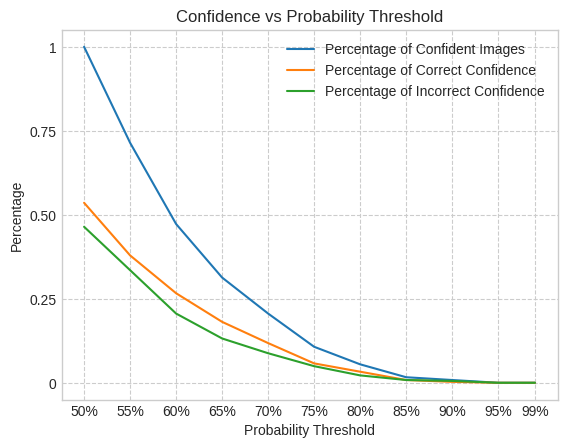

In [14]:
# plot probs vs percentage confident images
# plot probs vs percentage correct confident images
# plot probs vs percentage incorrect confident images
# plot probs vs average confidence
import matplotlib.pyplot as plt

probs = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
# percentage_confident_images = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
# precentage_correct_conf = [70, 75, 80, 85, 90, 92, 94, 96, 97, 98, 99]
# precentage_incorrect_conf = [30, 25, 20, 15, 10, 8, 6, 4, 3, 2, 1]
# percentage_avg_conf = [60, 62, 65, 67, 70, 72, 74, 76, 78, 80, 82]

# Set plot style
plt.style.use('seaborn-whitegrid')

# Create plot
fig, ax = plt.subplots()

# Add plot lines
ax.plot(probs, percentage_confident_images, label='Percentage of Confident Images')
ax.plot(probs, precentage_correct_conf, label='Percentage of Correct Confidence')
ax.plot(probs, precentage_incorrect_conf, label='Percentage of Incorrect Confidence')
# ax.plot(probs, percentage_avg_conf, label='Average Confidence')

# Add legend, labels, and title
ax.legend()
ax.set_xlabel('Probability Threshold')
ax.set_ylabel('Percentage')
ax.set_title('Confidence vs Probability Threshold')

# Customize tick labels
ax.set_xticks(probs)
ax.set_xticklabels(['50%', '55%', '60%', '65%', '70%', '75%', '80%', '85%', '90%', '95%', '99%'])
ax.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax.set_yticklabels(['0', '0.25', '0.50', '0.75', '1'])

# Add grid lines
ax.grid(True, which='major', linestyle='--')

# Show plot
plt.show()






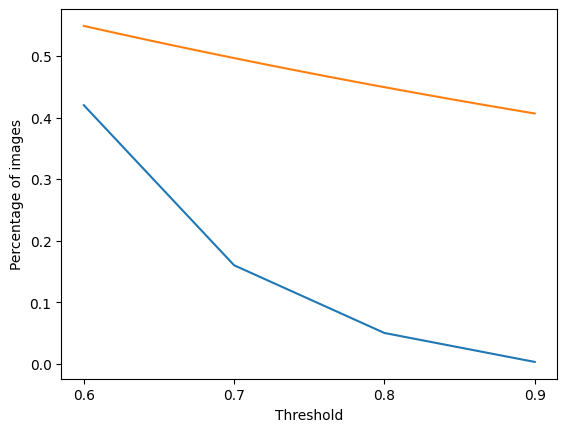

In [30]:
x = [0.6, 0.7, 0.8, 0.9]
y = [0.42, 0.16, 0.05, 0.003]

import matplotlib.pyplot as plt
import numpy as np

plt.plot(x, y)
plt.xlabel('Threshold')
plt.ylabel('Percentage of images')
plt.xticks(x)

# plot the e^-x function for x = 0.6 to 0.9 on the same plot
x = np.arange(0.6, 0.9, 0.01)
y = np.exp(-x)
plt.plot(x, y)
plt.show()
